<a href="https://colab.research.google.com/github/Tbarkin121/ML_Examples/blob/main/Pong_Actor_Critic_NoGradTape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://adventuresinmachinelearning.com/a2c-advantage-actor-critic-tensorflow-2/

In [1]:
%matplotlib inline
!pip install stable-baselines3[extra]

     |████████████████████████████████| 153kB 7.4MB/s 


In [2]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [3]:
import time
import datetime, os

import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

from collections import namedtuple, deque
import random

# Set seed for experiment reproducibility
# seed = 66
seed = 7777
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [22]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

# Create the environment
# env_id = 'Pong-ramNoFrameskip-v4'
# env = make_vec_env(env_id)
env_id = 'PongNoFrameskip-v4'
env = make_atari_env(env_id, n_envs=1, seed=seed) #monitor_dir=monitor_folder
env = VecFrameStack(env,n_stack=4)

# Box(4,) means that it is a Vector with 4 components
print("Observation space:", env.observation_space)
print("Shape:", env.observation_space.shape[0])
# Discrete(2) means that there is two discrete actions
print("Action space:", env.action_space)

# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n

print('num_obs = {}'.format(num_obs))
print('num_actions = {}'.format(num_actions))


state = tf.constant(env.reset(), dtype=tf.float32)
state_shape = state.shape[1:]
print('state_shape = {}'.format(state_shape))

Observation space: Box(0, 255, (84, 84, 4), uint8)
Shape: 84
Action space: Discrete(6)
num_obs = 84
num_actions = 6
state_shape = (84, 84, 4)


In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceReplay(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class ActorNet(tf.keras.Model):
  """Actor network."""
  def __init__(self, num_actions: int, num_hidden_units: int):
    """Initialize."""
    super().__init__()
    # self.actor_input = layers.Input(shape=(4))
    self.c1 = layers.Conv2D(32, (3, 3), activation='relu')
    self.mp1 = layers.MaxPooling2D((2, 2))

    self.d1 = layers.Dense(num_hidden_units)
    self.lr1 = layers.LeakyReLU()
    self.d2 = layers.Dense(num_hidden_units)
    self.lr2 = layers.LeakyReLU()
    self.a = layers.Dense(num_actions, activation='tanh')
    # self.a = layers.Dense(num_actions)
    # self.lr3 = keras.activation.tanh()


  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    # x = self.d1(inputs)
    # # x = tf.keras.activations.tanh(x)
    # x = self.lr1(x)
    # x = self.d2(x)
    # x = self.lr2(x)
    
    x = self.c1(inputs)
    x = self.mp1(x)
    x = layers.Flatten()(x)
    return self.a(x)

class CriticNet(tf.keras.Model):
  """Critic network."""
  def __init__(self, num_actions:int, num_hidden_units: int):
    """Initialize."""
    super().__init__()
    self.c1 = layers.Conv2D(32, (3, 3), activation='relu')
    self.mp1 = layers.MaxPooling2D((2, 2))

    # self.critic_input = layers.Input(shape=(4))
    self.d1 = layers.Dense(num_hidden_units)
    self.lr1 = layers.LeakyReLU()
    self.d2 = layers.Dense(num_hidden_units)
    self.lr2 = layers.LeakyReLU()
    # self.critic = layers.Dense(num_actions)
    self.c = layers.Dense(1)
    

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    # x = self.d1(inputs)
    # # x = tf.keras.activations.tanh(x)
    # x = self.lr1(x)
    # x = self.d2(x)
    # x = self.lr2(x)
    x = self.c1(inputs)
    x = self.mp1(x)
    x = layers.Flatten()(x)
    return self.c(x)

test_actor = ActorNet(num_actions, 64)
state = tf.constant(env.reset(), dtype=tf.float32)
output = test_actor( state )
print(output.shape)

(1, 6)


In [7]:
class Agent():
    def __init__(self, gamma = 0.99, mem_size = 100000, batch_size = 1024, mini_batch_size = 128, n_mini_batches=1):
        self.gamma = gamma
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.mini_batch_size = mini_batch_size
        self.n_mini_batches = n_mini_batches
        self.memory = ExperienceReplay(self.mem_size)

        self.a_opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.c_opt = tf.keras.optimizers.Adam(learning_rate=1e-3)


        self.actor = ActorNet(num_actions, 64)
        self.critic = CriticNet(num_actions, 64)

        self.actor.compile(
                    optimizer='adam')

        self.critic.compile(
                    optimizer='adam')
        
        self.huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

        self.I = 1
        
    def act(self, state, deterministic=False):
        logits = self.actor(state)
        if (deterministic):
            action = tf.argmax(logits, 1)[0]
        else:
            # action = tf.random.categorical(logits, 1)[0, 0]
            # logits = logits + 1
            probs = tf.nn.softmax(logits)
            log_probs = tf.math.log(probs)
            # print('logits = \n{}'.format(logits))
            # print('probs = \n{}'.format(probs))
            # print('log_probs = \n{}'.format(log_probs))
            action = tf.random.categorical(log_probs, 1)[0, 0]

        return tf.expand_dims(action, 0)

    def reset_replay_buffer(self):
        # Reset memory buffer
        self.memory = ExperienceReplay(self.mem_size)
    
    def fill_replay_buff(self, n_samples):        
        # Reset Environment
        state = tf.constant(env.reset(), dtype=tf.float32)
        # Convert state into a batched tensor (batch size = 1)
        # state = tf.expand_dims(state, 0) #Don't need for vec env? State shape didnt need expand_dims

        for i in range(n_samples):
          
          # Run the model and to get action probabilities and critic value
          action = self.act(state)
          # print('action = {}'.format(action))
          # Apply action to the environment to get next state and reward
          next_state, reward, done = tf_env_step(action)
          # next_state = tf.expand_dims(next_state, 0)
          # print('next_state = {}'.format(next_state))
          # print('reward = {}'.format(reward))
          # print('done = {}'.format(done))
          # Store the transition in memory
          # print('')
          #If Episode is done, reset the environment
          if tf.cast(done, tf.bool):
            self.memory.push(state, action, next_state, [0], done)
            state = tf.constant(env.reset(), dtype=tf.float32)
            # state = tf.expand_dims(state, 0)
          else:
            self.memory.push(state, action, next_state, reward, done)
            state=next_state

    # @tf.function
    def train(self, n_mini_batches = 1):
        self.fill_replay_buff(self.batch_size)
        
        for _ in range(n_mini_batches):
            mini_batch = self.memory.sample(self.mini_batch_size)
            # mini_batch = list(agent.memory.memory)[0:self.mini_batch_size]
            mini_batch = Transition(*zip(*mini_batch))
            
            tmp_state_shape = tf.TensorShape(self.mini_batch_size)
            tmp_action_shape = tmp_state_shape.concatenate(1)
            tmp_state_shape = tmp_state_shape.concatenate(state_shape)

            state_t1 = tf.reshape(mini_batch[0], shape=tmp_state_shape)
            action_t1 = tf.reshape(mini_batch[1], shape=tmp_action_shape)
            state_t2 = tf.reshape(mini_batch[2], shape=tmp_state_shape)
            reward_t2 = tf.reshape(mini_batch[3], shape=tmp_action_shape)
            done = tf.reshape(mini_batch[4], shape=tmp_action_shape)
          
            with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
                logits = self.actor(state_t1, training=True)
                values_t1 = self.critic(state_t1, training=True)
                values_t2 = self.critic(state_t2, training=True)
                # print('logits = {}'.format(logits))
                # print('action_t1 = {}'.format(action_t1))
                
                # print('logit_actions = {}'.format(logit_actions))
                # print('logit_actions.shape = {}'.format(logit_actions.shape))
                # time.sleep(5)

                probs = tf.nn.softmax(logits)
                probs_actions = tf.gather(probs, action_t1, axis=1, batch_dims=1)
                log_probs = tf.math.log(probs_actions)
                # print('probs_actions = {}'.format(probs_actions))
                # print('probs_actions.shape = {}'.format(probs_actions.shape))
                # print('log_probs = {}'.format(log_probs))
                # print('log_probs.shape = {}'.format(log_probs.shape))
                # time.sleep(5)
                returns = tf.cast(reward_t2, 'float32') + self.gamma*values_t2*(1-tf.cast(done, 'float32'))
                # returns = -tf.cast(done, 'float32') + self.gamma*values_t2*(1-tf.cast(done, 'float32'))
                advantage =  returns - values_t1 

                entropy_loss = tf.math.reduce_mean(probs_actions*log_probs)
                # actor_loss = -log_probs*advantage
                actor_loss = tf.math.reduce_mean(-self.I*log_probs * advantage) - 0.01*entropy_loss
                self.I *= self.gamma
                # critic_loss = 0.5*self.huber_loss(values_t1, returns)
                critic_loss = 0.5*tf.math.reduce_mean(advantage**2)

                
                
            grads1 = tape1.gradient(actor_loss, self.actor.trainable_variables)
            grads2 = tape2.gradient(critic_loss, self.critic.trainable_variables)

            self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
            self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))

        # return actor_loss, critic_loss
    def summary(self):
        pass
        # state = tf.constant(env.reset(), dtype=tf.float32)
        # state = tf.expand_dims(state, 0)
        # self.actor.build(input_shape=(1,4))
        # self.actor.summary()
        # self.critic.build(input_shape=(1,4))
        # self.critic.summary()

In [8]:
agent = Agent(mem_size=1000, batch_size=100, mini_batch_size=10, n_mini_batches=10)
agent.reset_replay_buffer()
agent.fill_replay_buff(1000)
mini_batch = list(agent.memory.memory)
mini_batch = Transition(*zip(*mini_batch))


tmp_state_shape = tf.TensorShape(len(mini_batch[0]))
tmp_action_shape = tmp_state_shape.concatenate(1)
tmp_state_shape = tmp_state_shape.concatenate(state_shape)


state_t1 = tf.reshape(mini_batch[0], shape=tmp_state_shape)
action_t1 = tf.reshape(mini_batch[1], shape=tmp_action_shape)
state_t2 = tf.reshape(mini_batch[2], shape=tmp_state_shape)
reward_t2 = tf.reshape(mini_batch[3], shape=tmp_action_shape)
done = tf.reshape(mini_batch[4], shape=tmp_action_shape)


# print(state_t1)

In [9]:
test_idx = 137
print('reward = {}'.format(mini_batch[3][test_idx]))
print('done = {}'.format(mini_batch[4][test_idx]))

reward = [0]
done = [0]


In [15]:
agent = Agent(mem_size=1000, batch_size=100, mini_batch_size=10, n_mini_batches=10)
state = tf.constant(env.reset(), dtype=tf.float32)
action = agent.act(state, deterministic=True)
print(state.shape)
print('')
print(action.shape)
print('')
next_state, reward, done = tf_env_step(action)
print(next_state.shape)
# logits = agent.actor(state)
# print('logits = {}'.format(logits))

RuntimeError: ignored

In [11]:
#Run An Episode
def Run_An_Episode():
    episode_reward = 0
    state = tf.constant(env.reset(), dtype=tf.float32)
    # state = tf.expand_dims(state, 0)
    logits = agent.actor(state)
    probs = tf.nn.softmax(logits)
    log_probs = tf.math.log(probs)
    p = probs.numpy()
    lp = log_probs.numpy()
    # print('p(a1) = {}. p(a2) = {}'.format(lp[0][0],lp[0][1]))
    while (True):
        action = agent.act(state, deterministic=True)
        # print('action_logits_t = {}'.format(action_logits_t))
        
        # print('action = {}'.format(action))
        # Apply action to the environment to get next state and reward
        state, reward, done = tf_env_step(action)
        # state = tf.expand_dims(state, 0)
        episode_reward += reward[0]
        if (tf.cast(done, tf.bool)):
            env.reset()
            break
    return episode_reward.numpy()

In [18]:
# Make a fresh agent
# agent = Agent(mem_size=10000, gamma=0.99, batch_size=200, mini_batch_size=1000, n_mini_batches=10)
agent = Agent(mem_size=10000, gamma=0.99, batch_size=200, mini_batch_size=1000, n_mini_batches=1)
agent.fill_replay_buff(1000)


In [19]:
# Run Some Training
min_episodes_criterion = 100
max_episodes = 1000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0


# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    agent.train(agent.n_mini_batches)

    

    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      episode_reward = Run_An_Episode()
      episodes_reward.append(episode_reward)
      running_reward = statistics.mean(episodes_reward)

      t.set_description(f'Episode {i}')
      t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)
      # print(f'Episode {i}: average reward: {avg_reward}')

    if running_reward > reward_threshold and i >= min_episodes_criterion:  
      break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 910:  92%|█████████▏| 915/1000 [27:37<02:34,  1.81s/it, episode_reward=-14, running_reward=-14]


RuntimeError: ignored

In [ ]:
action = agent.act(state)
actor_out = agent.actor(state)
print(actor_out)

In [ ]:
print(agent.actor(state))


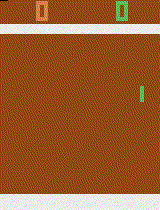

In [28]:
# Render an episode and save as a GIF file
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    action = agent.act(state, deterministic=True)
    # action = agent.act(state, deterministic=False)
    state, reward, done = tf_env_step(action)

    # Render screen every n steps
    n=5

    if i % n == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(env, agent.actor, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

In [ ]:
state = tf.constant(env.reset(), dtype=tf.float32)
logits = agent.actor(state)
print(logits)